In [30]:
import sys

sys.path.append("/app")
from src.climate_learn import IterDataModule
from src.climate_learn.utils import visualize_at_index, visualize_mean_bias
from src.climate_learn import load_downscaling_module
from src.climate_learn.utils.gis import (
    prepare_ynet_climatology,
    prepare_deepsd_elevation,
)

from src.climate_learn.models.module import (
    DeepSDLitModule,
    DiffusionLitModule,
    LitModule,
    YnetLitModule,
    DeepSDLitModule,
)
from src.climate_learn.data.processing.era5_constants import (
    DEFAULT_PRESSURE_LEVELS,
    PRESSURE_LEVEL_VARS,
)
import torch
from torchvision import transforms

### Load models and data

In [31]:
# Set up data
variables = [
    "land_sea_mask",
    "orography",
    "lattitude",
    "toa_incident_solar_radiation",
    "2m_temperature",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "geopotential",
    "temperature",
    "relative_humidity",
    "specific_humidity",
    "u_component_of_wind",
    "v_component_of_wind",
]
in_vars = []
for var in variables:
    if var in PRESSURE_LEVEL_VARS:
        for level in DEFAULT_PRESSURE_LEVELS:
            in_vars.append(var + "_" + str(level))
    else:
        in_vars.append(var)

dm = IterDataModule(
    task="downscaling",
    inp_root_dir="/app/data/ClimateLearn/processed/weatherbench/era5/5.625deg",
    out_root_dir="/app/data/ClimateLearn/processed/weatherbench/era5/2.8125deg",
    in_vars=in_vars,
    out_vars=["2m_temperature", "temperature_850", "geopotential_500"],
    subsample=1,
    batch_size=1,
    num_workers=4,
)
dm.setup()

In [32]:
# Retrieve the shape of the 2m temperature data from the first item in the test dataset
temperature_shape = next(iter(dm.data_test.dataset.dataset))[0]["2m_temperature"].shape
print(f"Shape of 2m temperature data: {temperature_shape}")

# Get the shape of the first batch of data from the test dataloader
first_batch_shape = next(iter(dm.test_dataloader()))[0].shape
print(f"Shape of the first batch from test dataloader: {first_batch_shape}")

in_vars, out_vars = dm.get_data_variables()
in_shape, out_shape = dm.get_data_dims()
in_channels, in_height, in_width = in_shape[1:]
out_channels, out_height, out_width = out_shape[1:]

# Printing detailed information about input and output shapes for clarity
print(
    f"Input Channels = {in_channels}, Input Height = {in_height}, Input Width = {in_width}"
)
print(
    f"Output Channels = {out_channels}, Output Height = {out_height}, Output Width = {out_width}"
)

Shape of 2m temperature data: (546, 32, 64)
Shape of the first batch from test dataloader: torch.Size([1, 49, 32, 64])
Input Channels = 49, Input Height = 32, Input Width = 64
Output Channels = 3, Output Height = 64, Output Width = 128


In [33]:
vit = load_downscaling_module(data_module=dm, architecture="vit")
unet = load_downscaling_module(data_module=dm, architecture="unet")
resnet = load_downscaling_module(data_module=dm, architecture="resnet")
# samvit = load_downscaling_module(data_module=dm, architecture="samvit")
ynet = load_downscaling_module(data_module=dm, architecture="ynet", upsampling=None)
deepsd = load_downscaling_module(data_module=dm, architecture="deepsd", upsampling=None)
# diffusion = load_downscaling_module(data_module=dm, architecture="diffusion", upsampling=None)

In [35]:
vit = LitModule.load_from_checkpoint(
            checkpoint_path="/app/data/experiments/downscaling-ERA-ERA/vit_multi_bilinear_0/logs/version_0/checkpoints/epoch_039.ckpt",
            net=vit.net,
            optimizer=vit.optimizer,
            lr_scheduler=None,
            train_loss=None,
            val_loss=None,
            test_loss=vit.test_loss,
            test_target_transforms=vit.test_target_transforms,)
unet = LitModule.load_from_checkpoint(
            checkpoint_path="/app/data/experiments/downscaling-ERA-ERA/unet_multi_bilinear_123/logs/version_0/checkpoints/epoch_033.ckpt",
            net=unet.net,
            optimizer=unet.optimizer,
            lr_scheduler=None,
            train_loss=None,
            val_loss=None,
            test_loss=unet.test_loss,
            test_target_transforms=unet.test_target_transforms,)
resnet = LitModule.load_from_checkpoint(
            checkpoint_path="/app/data/experiments/downscaling-ERA-ERA/resnet_multi_bilinear_777/logs/version_0/checkpoints/epoch_033.ckpt",
            net=resnet.net,
            optimizer=resnet.optimizer,
            lr_scheduler=None,
            train_loss=None,
            val_loss=None,
            test_loss=resnet.test_loss,
            test_target_transforms=resnet.test_target_transforms,)
# # diffusion = DiffusionLitModule.load_from_checkpoint(
# #             checkpoint_path="/app/data/experiments/downscaling-ERA-ERA/diffusion_multi_none_777/logs/version_3/checkpoints/epoch_029.ckpt",
# #             net=diffusion.net,
# #             optimizer=diffusion.optimizer,
# #             lr_scheduler=None,
# #             train_loss=None,
# #             val_loss=None,
# #             test_loss=diffusion.test_loss,
# #             test_target_transforms=diffusion.test_target_transforms,)
normalized_clim = prepare_ynet_climatology(dm, "/app/data/elevation.nc", out_vars)
ynet = YnetLitModule.load_from_checkpoint(
            checkpoint_path="/app/data/experiments/downscaling-ERA-ERA/ynet_multi_none_777/logs/version_0/checkpoints/epoch_024.ckpt",
            net=ynet.net,
            optimizer=ynet.optimizer,
            lr_scheduler=None,
            train_loss=None,
            val_loss=None,
            test_loss=ynet.test_loss,
            test_target_transforms=ynet.test_target_transforms,
            normalized_clim=normalized_clim)
elevation_list = prepare_deepsd_elevation(dm, path_to_elevation="/app/data/elevation.nc")
deepsd = DeepSDLitModule.load_from_checkpoint(
            checkpoint_path="/app/data/experiments/downscaling-ERA-ERA/deepsd_multi_none_123/logs/version_0/checkpoints/epoch_030.ckpt",
            net=deepsd.net,
            optimizer=deepsd.optimizer,
            lr_scheduler=None,
            train_loss=None,
            val_loss=None,
            test_loss=deepsd.test_loss,
            test_target_transforms=deepsd.test_target_transforms,
            elevation=elevation_list)

0it [00:00, ?it/s]


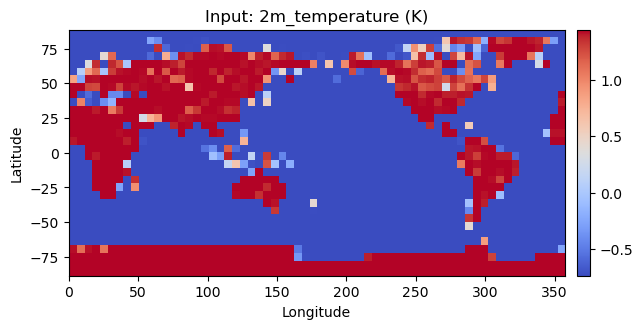

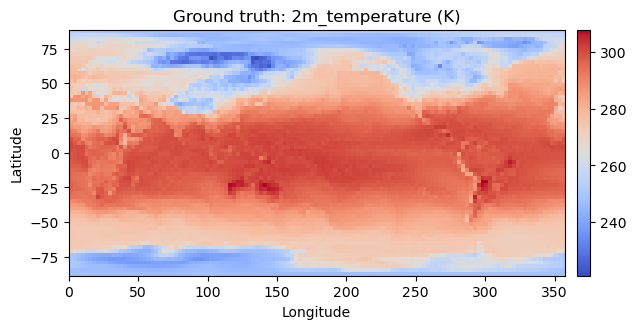

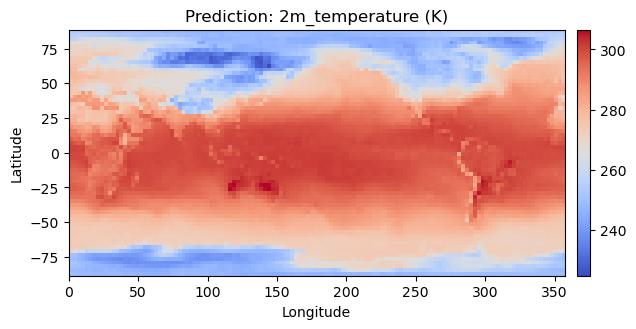

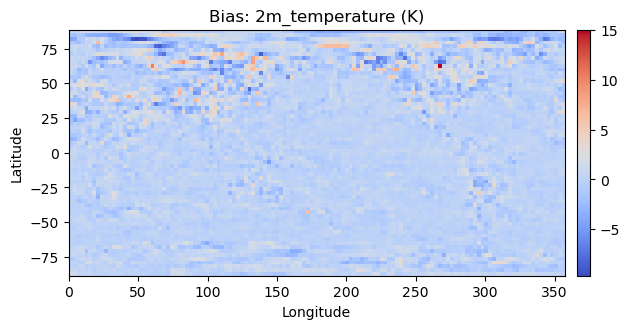

In [17]:
denorm = vit.test_target_transforms[0]
in_graphic = visualize_at_index(
    vit.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(49), torch.ones(49)),
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:01, ?it/s]


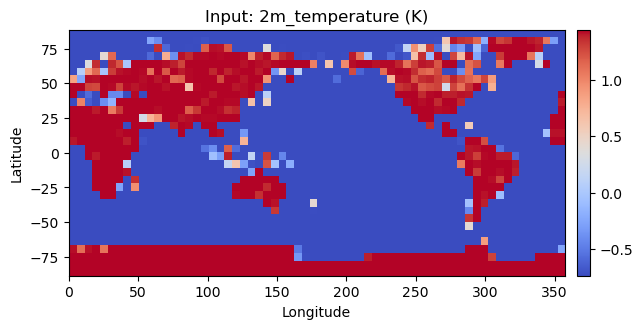

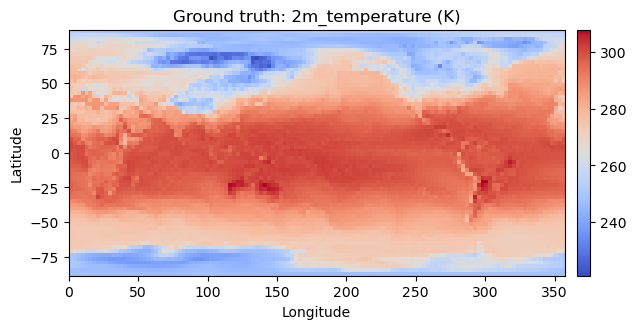

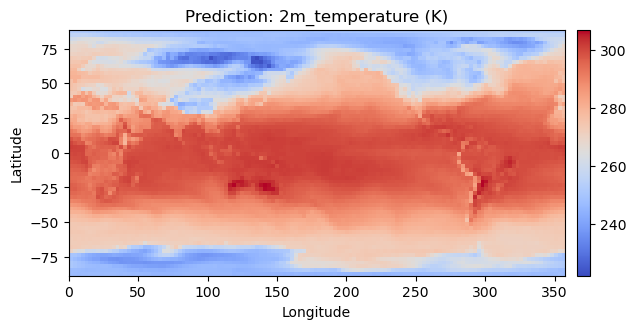

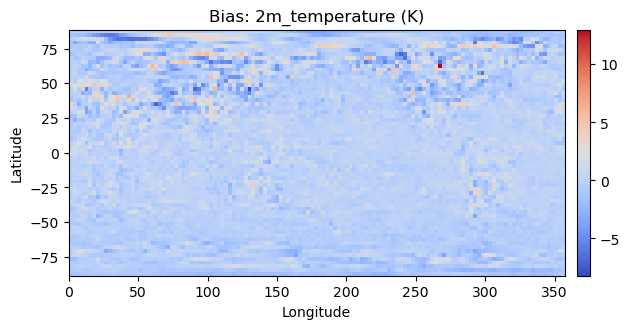

In [18]:
in_graphic = visualize_at_index(
    unet.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(49), torch.ones(49)),
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]


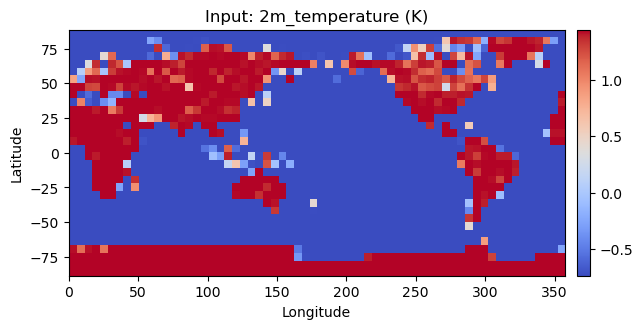

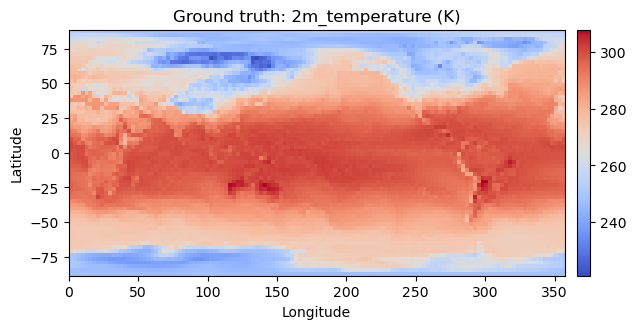

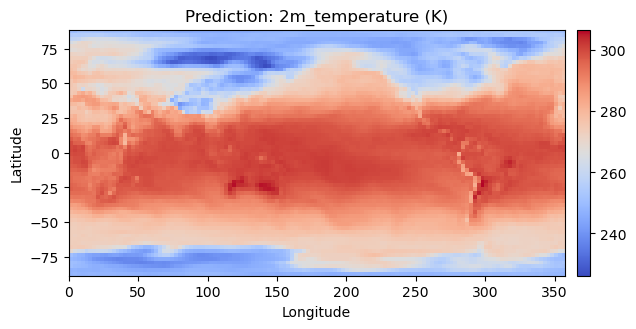

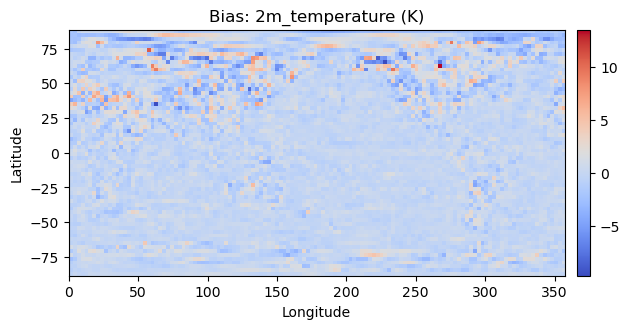

In [36]:
in_graphic = visualize_at_index(
    deepsd.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(49), torch.ones(49)),
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0,
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]


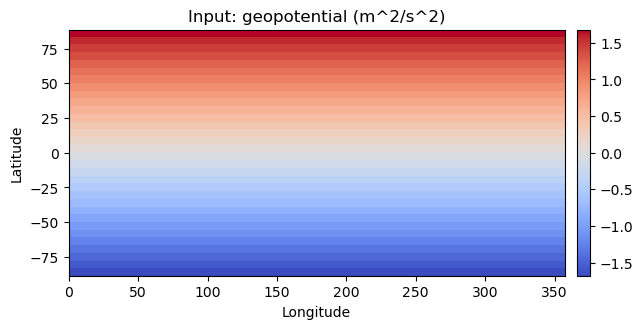

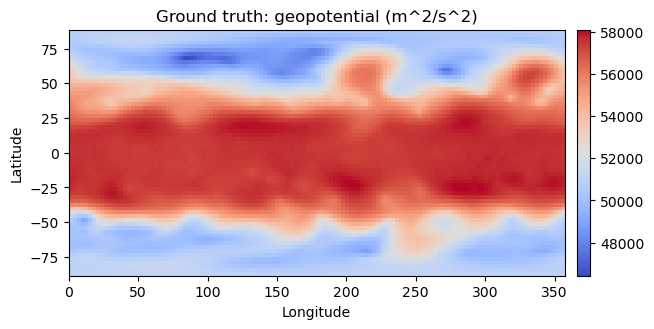

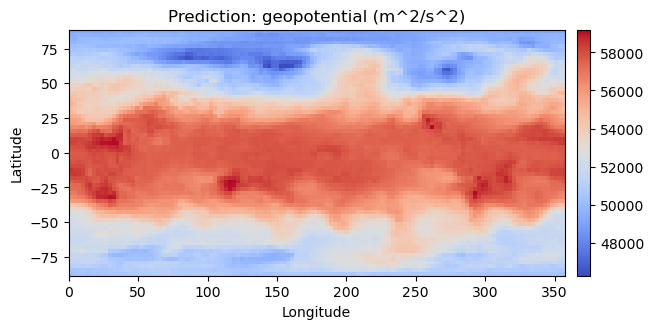

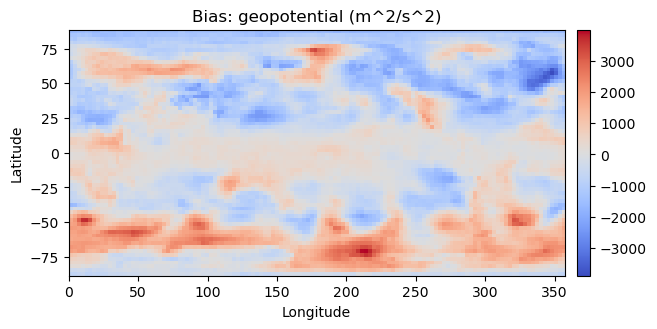

In [39]:
denorm = vit.test_target_transforms[0]
in_graphic = visualize_at_index(
    vit.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(49), torch.ones(49)),
    out_transform=denorm,
    variable="geopotential_500",
    src="era5",
    index=0,
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]


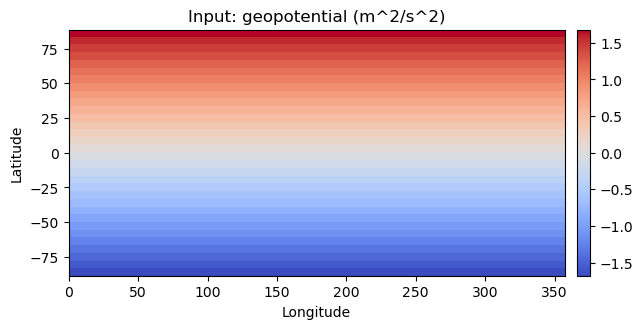

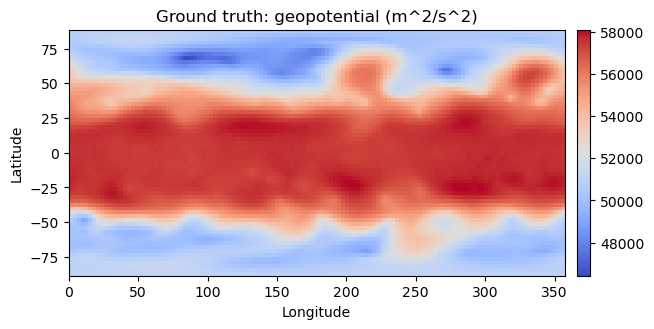

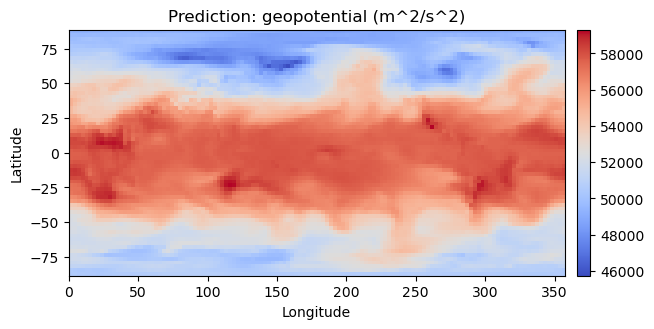

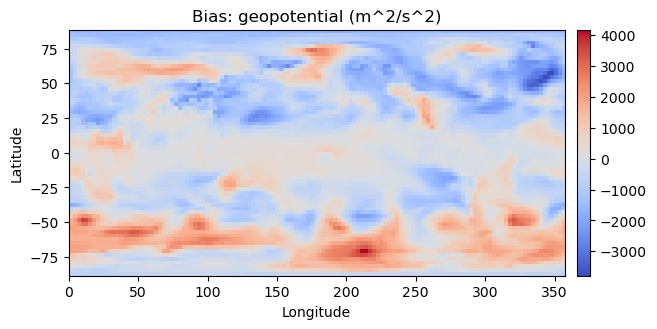

In [40]:
in_graphic = visualize_at_index(
    unet.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(49), torch.ones(49)),
    out_transform=denorm,
    variable="geopotential_500",
    src="era5",
    index=0,
)

0it [00:00, ?it/s]


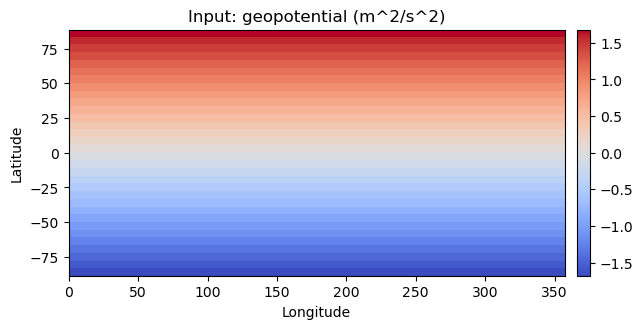

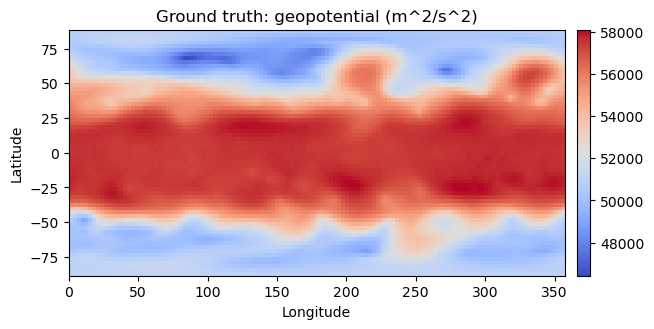

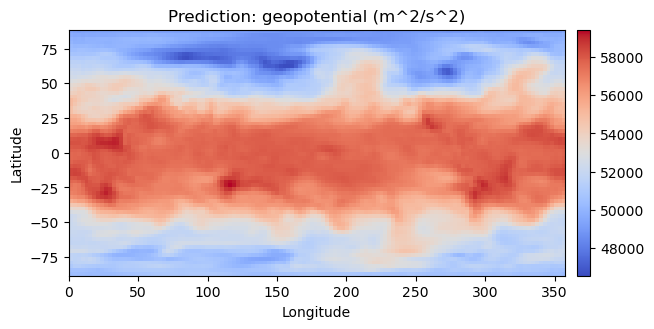

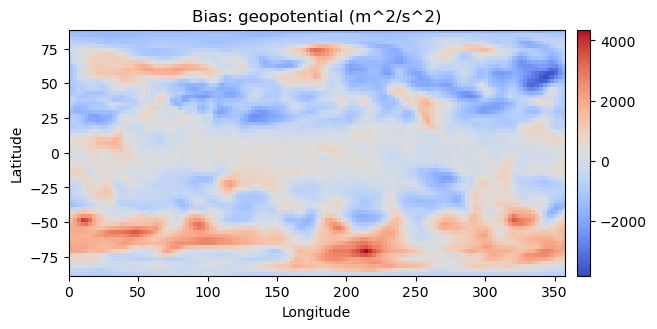

In [41]:
in_graphic = visualize_at_index(
    deepsd.to(device="cuda:2"),
    dm,
    in_transform=transforms.Normalize(torch.zeros(49), torch.ones(49)),
    out_transform=denorm,
    variable="geopotential_500",
    src="era5",
    index=0,
)